In [1]:
# 필요한 모듈 import
import fn_files as fn

from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
rc('font',family = 'Malgun Gothic')
import warnings
warnings.filterwarnings(action='ignore')
import numpy as np
import pandas as pd
import copy
import json
import math
np.random.seed(0)

In [2]:
train_data =pd.read_json('data_v3_COM.json',orient='table')
test_data = pd.read_json('test_data_v2_COM.json',orient='table')

### 데이터 준비

In [3]:
test_data = fn.fn_test_data_v2(test_data,train_data)


총노출, 누적노출, 노출비율 변수 완료
기상 데이터 변수 완료
미세먼지 데이터 변수 완료



소비지출전망 변수 완료
방송시작,방송종료,요일,시간대,Hour 변수 완료
pk_time_01 변수 완료



pk_times_prd 변수 완성



pk_times_tot 변수 완성
NS shop 주가 변수 완성
온라인 쇼핑몰 거래액 변수 완료



지난 2회 실적 가중치 변수 완료



지난 3회 실적 가중치 변수 완료
상품군별 시간대 가중치 완료
시간_범주 변수 완료


In [4]:
test_data['마더코드'] = test_data['마더코드'].apply(lambda x: int(x))
test_data['상품코드'] = test_data['상품코드'].apply(lambda x: int(x))
test_data['판매단가'] = test_data['판매단가'].apply(lambda x: int(x))
test_data['방송_월'] = test_data['방송_월'].apply(lambda x:int(x))
test_data['방송_일'] = test_data['방송_일'].apply(lambda x:int(x))
test_data['판매일수'] = test_data['판매일수'].apply(lambda x:int(x))

In [5]:
test_data.isna().sum()

방송일시               0
노출(분)              0
마더코드               0
상품코드               0
상품명                0
상품군                0
판매단가               0
취급액             2891
브랜드                0
상품종류               0
브랜드상품              0
방송날짜               0
방송_월               0
방송_일               0
판매일수               0
검색률2               0
총노출(분)             0
누적노출(분)            0
lng_time           0
강수량(mm)            0
기온(°C)             0
습도(%)              0
기온_int             0
1시간평균 미세먼지농도       0
소비지출전망CSI          0
소비자심리지수            0
방송시작               0
방송종료               0
요일                 0
시간대                0
Hour               0
pk_time_01         0
pk_times_prd       0
pk_times_tot       0
Open               0
온라인 쇼핑몰 거래액        0
two_amt            0
three_amt          0
time_weight        0
시간_범주              0
성별                 0
일/무                0
상품차이               0
dtype: int64

In [6]:
def MAPE(y_true, y_pred):
    if y_true == 0:
        return 0
    else:
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.abs((y_true - y_pred) / y_true)

## Training

In [7]:
from lightgbm import LGBMRegressor,plot_importance
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
import lightgbm as lgb

from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()

In [8]:
def logg(x):
    if x == 0:
        return 0
    else:
        return np.log(x)
    
train_data['ln판매단가'] = list(map(logg,train_data['판매단가']))
train_data['ln수량'] = list(map(logg,train_data['수량']))

In [9]:
df = train_data[['노출(분)', '마더코드', '상품코드','상품군', '판매단가', '취급액','수량','검색률2',
       'lng_time','강수량(mm)', '습도(%)', '기온_int', '1시간평균 미세먼지농도', '소비지출전망CSI',
       '소비자심리지수','요일', 'pk_time_01', 'pk_times_prd', 'Open', '온라인 쇼핑몰 거래액','two_amt',
        '시간_범주', '성별', '일/무', '상품차이','방송_월',"ln수량","ln판매단가"]]

encoder.fit(df['요일'])
df['요일'] = encoder.transform(df['요일'])

encoder.fit(df['시간_범주'])
df['시간_범주'] = encoder.transform(df['시간_범주'])

encoder.fit(df['상품군'])
df['상품군'] = encoder.transform(df['상품군'])

df['상품군'] = df['상품군'].astype('category')
df['방송_월'] = df['방송_월'].astype('category')
df['요일'] = df['요일'].astype('category')
df['시간_범주'] = df['시간_범주'].astype('category')
df['성별'] = df['성별'].astype('category')
df['일/무'] = df['일/무'].astype('category')
df['상품차이'] = df['상품차이'].astype('category')

In [10]:
cloths = df[df['상품군']==6]
inwear = df[df['상품군']==5]
kitchen = df[df['상품군']==9]
food = df[df['상품군']==3]
skin = df[df['상품군']==7]
digital = df[df['상품군']==1]
items = df[df['상품군']==4]
health = df[df['상품군']==2]
stuff = df[df['상품군']==8]
furni = df[df['상품군']==0]
bedd = df[df['상품군']==10]

In [11]:
X1 = cloths[cloths.columns.difference(["취급액","수량",'판매단가','ln수량'])]
y1 = cloths["ln수량"]
X1_train, X1_test, y1_train, y1_test = train_test_split(X1,y1,test_size=0.2,random_state=42)

X2 = inwear[inwear.columns.difference(["취급액","수량",'판매단가','ln수량'])]
y2 = inwear["ln수량"]
X2_train, X2_test, y2_train, y2_test = train_test_split(X2,y2,test_size=0.2,random_state=42)

X3 = kitchen[kitchen.columns.difference(["취급액","수량",'판매단가','ln수량'])]
y3 = kitchen["ln수량"]
X3_train, X3_test, y3_train, y3_test = train_test_split(X3,y3,test_size=0.2,random_state=42)

X4 = food[food.columns.difference(["취급액","수량",'판매단가','ln수량'])]
y4 = food["ln수량"]
X4_train, X4_test, y4_train, y4_test = train_test_split(X4,y4,test_size=0.2,random_state=42)

X5 = skin[skin.columns.difference(["취급액","수량",'판매단가','ln수량'])]
y5 = skin["ln수량"]
X5_train, X5_test, y5_train, y5_test = train_test_split(X5,y5,test_size=0.2,random_state=42)

X6 = digital[digital.columns.difference(["취급액","수량",'판매단가','ln수량'])]
y6 = digital["ln수량"]
X6_train, X6_test, y6_train, y6_test = train_test_split(X6,y6,test_size=0.2,random_state=42)

X7 = items[items.columns.difference(["취급액","수량",'판매단가','ln수량'])]
y7 = items["ln수량"]
X7_train, X7_test, y7_train, y7_test = train_test_split(X7,y7,test_size=0.2, random_state=42)

X8 = health[health.columns.difference(["취급액","수량",'판매단가','ln수량'])]
y8 = health["ln수량"]
X8_train, X8_test, y8_train, y8_test = train_test_split(X8,y8,test_size=0.2,random_state=42)

X9 = stuff[stuff.columns.difference(["취급액","수량",'판매단가','ln수량'])]
y9 = stuff["ln수량"]
X9_train, X9_test, y9_train, y9_test = train_test_split(X9,y9,test_size=0.2,random_state=42)

X10 = furni[furni.columns.difference(["취급액","수량",'판매단가','ln수량'])]
y10 = furni["ln수량"]
X10_train, X10_test, y10_train, y10_test = train_test_split(X10,y10,test_size=0.2,random_state=42)

X11 = bedd[bedd.columns.difference(["취급액","수량",'판매단가','ln수량'])]
y11 = bedd["ln수량"]
X11_train, X11_test, y11_train, y11_test = train_test_split(X11,y11,test_size=0.2,random_state=42)

X_train = pd.concat([X1_train,X2_train,X3_train,X4_train,X5_train,X6_train,X7_train,X8_train,X9_train,X10_train,X11_train])
X_valid = pd.concat([X1_test,X2_test,X3_test,X4_test,X5_test,X6_test,X7_test,X8_test,X9_test,X10_test,X11_test])
y_train = pd.concat([y1_train,y2_train,y3_train,y4_train,y5_train,y6_train,y7_train,y8_train,y9_train,y10_train,y11_train])
y_valid = pd.concat([y1_test,y2_test,y3_test,y4_test,y5_test,y6_test,y7_test,y8_test,y9_test,y10_test,y11_test])

In [12]:
lgbm_r=LGBMRegressor()

gridParams = {
    'learning_rate': [0.1,0.01],
    'boosting_type' : ['gbdt'],
    'max_depth' : [12,14,16,18,20],
    'objective' : ['regression'],
    'feature_fraction' : [0.7, 0.8,0.9,0.6],
    'bagging_fraction' : [0.7, 0.8,0.6],
    'metric' : ['mse']
}

params = gridParams
model = lgb.LGBMRegressor()

grid = GridSearchCV(model, gridParams,
                    verbose=0,
                    cv=4,
                    n_jobs=-1)

grid.fit(X_train, y_train)

grid.best_params_

[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


{'bagging_fraction': 0.7,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.6,
 'learning_rate': 0.1,
 'max_depth': 14,
 'metric': 'mse',
 'objective': 'regression'}

In [13]:
params['feature_fraction'] = grid.best_params_['feature_fraction']
params['learning_rate'] = grid.best_params_['learning_rate']
params['bagging_fraction'] = grid.best_params_['bagging_fraction']
params['max_depth'] = grid.best_params_['max_depth']
print('Fitting with params: ')
print(params)

Fitting with params: 
{'learning_rate': 0.1, 'boosting_type': ['gbdt'], 'max_depth': 14, 'objective': ['regression'], 'feature_fraction': 0.6, 'bagging_fraction': 0.7, 'metric': ['mse']}


In [14]:
train_ds = lgb.Dataset(X_train, label = y_train) 
valid_ds = lgb.Dataset(X_valid, label = y_valid)

model = lgb.train(params, train_ds, 10000, valid_ds, verbose_eval=100, early_stopping_rounds=1000)

[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007316 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2361
[LightGBM] [Info] Number of data points in the train set: 30105, number of used features: 24
[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves
[LightGBM] [Warning] Find whitespaces in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 4.231181
Training until validation scores don't improve for 1000 rounds
[100]	valid_0's l2: 0.34495
[200]	valid_0's l2: 0.31477
[300]	valid_0's l2: 0.297078
[400]	valid_0's l2: 0.287759
[500]	valid_0's l2: 0.281729
[600]	valid_0's l2: 0.27669
[700]	valid_0's l2: 0.272409
[800]	valid_0's l2: 0.269096

In [15]:
y_pred = model.predict(X_train)
y_pred = np.exp(y_pred)
y_pred = np.array(train_data[train_data.index.isin(y_train.index.tolist())]['판매단가'][y_train.index]*y_pred).tolist()
real = train_data[train_data.index.isin(y_train.index.tolist())]['취급액'][y_train.index].tolist()
ss = []
for i in range(len(y_pred)):
    ss.append(MAPE(real[i],y_pred[i]))
mape=np.array(ss).mean()*100
print('lightgbm model train data mape: ',mape)

lightgbm model train data mape:  12.46571294863214


In [16]:
y_pred = model.predict(X_valid)
y_pred = np.exp(y_pred)
y_pred = np.array(train_data[train_data.index.isin(y_valid.index.tolist())]['판매단가'][y_valid.index]*y_pred).tolist()
real = train_data[train_data.index.isin(y_valid.index.tolist())]['취급액'][y_valid.index].tolist()
ss = []
for i in range(len(y_pred)):
    ss.append(MAPE(real[i],y_pred[i]))
mape=np.array(ss).mean()*100
print('lightgbm model test data mape: ',mape)

lightgbm model test data mape:  31.48268216297981


<Figure size 720x576 with 0 Axes>

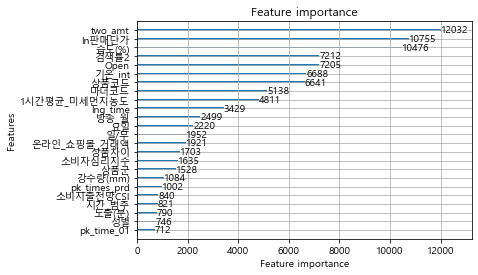

In [17]:
plt.figure(figsize=(10,8))
lgb.plot_importance(model)
plt.show()

In [18]:
model.params

{'learning_rate': 0.1,
 'boosting_type': ['gbdt'],
 'max_depth': 14,
 'objective': ['regression'],
 'feature_fraction': 0.6,
 'bagging_fraction': 0.7,
 'metric': ['mse'],
 'num_iterations': 10000,
 'early_stopping_round': 1000,
 'categorical_column': [12, 13, 14, 16, 20, 22, 23]}

## Predicting

In [19]:
test_data['ln판매단가'] = list(map(logg,test_data['판매단가']))

ttest_data = test_data[test_data['상품군']!='무형']

df = ttest_data[['노출(분)', '마더코드', '상품코드','상품군',"판매단가", '취급액','검색률2',
       'lng_time','강수량(mm)', '습도(%)', '기온_int', '1시간평균 미세먼지농도', '소비지출전망CSI',
       '소비자심리지수','요일', 'pk_time_01', 'pk_times_prd', 'Open', '온라인 쇼핑몰 거래액','two_amt',
        '시간_범주', '성별', '일/무', '상품차이','방송_월',"ln판매단가"]]

encoder.fit(df['요일'])
df['요일'] = encoder.transform(df['요일'])

encoder.fit(df['시간_범주'])
df['시간_범주'] = encoder.transform(df['시간_범주'])

encoder.fit(df['상품군'])
df['상품군'] = encoder.transform(df['상품군'])

df['상품군'] = df['상품군'].astype('category')
df['방송_월'] = df['방송_월'].astype('category')
df['요일'] = df['요일'].astype('category')
df['시간_범주'] = df['시간_범주'].astype('category')
df['성별'] = df['성별'].astype('category')
df['일/무'] = df['일/무'].astype('category')
df['상품차이'] = df['상품차이'].astype('category')

In [20]:
X_test = df[df.columns.difference(["취급액",'판매단가'])]

In [21]:
y_pred = model.predict(X_test)
y_pred = np.exp(y_pred)
y_pred = y_pred*ttest_data['판매단가']

In [22]:
del test_data['취급액']

In [23]:
ttest_data['취급액'] = y_pred

In [24]:
test_data = pd.merge(test_data,ttest_data[['방송일시', '노출(분)', '마더코드', '상품코드', '상품명', '상품군', '판매단가', '취급액']],how='left')

In [25]:
test_data['취급액'] = test_data['취급액'].fillna(0)

In [26]:
y_pred

0       1.414276e+07
1       1.920918e+07
2       2.737607e+07
3       1.396547e+07
4       2.240179e+07
            ...     
2883    8.120337e+06
2884    1.556150e+07
2885    1.948713e+07
2889    9.025916e+06
2890    9.631260e+06
Name: 판매단가, Length: 2716, dtype: float64

In [27]:
test_data.to_csv('평가데이터_최종.csv',index=False, encoding='euc-kr')